# Optimización de las transiciones de una red de Damman con PySwarms

**Autor**: Ángela Soria García + Luis Miguel Sánchez Brea

**Fecha**: 11/10/2021

**Objetivo**: Desarrollar un procedimiento de optimización para las transiciones de una red de Damman.

**Descripción**: Implementamos una función que calcule las eficiencias del órdenes de difracción de la red de Damman. Las expresiones utilizadas son las dadas en el Optixplorer_Manual_v2.8d (pág 29). Con la librería PySwarms optimizamos estas transiciones para que la energía de todos los órdenes sea igual.

Voy a intentar dividir la función de ejecución de la función de mérito

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx
from pyswarms.single.global_best import GlobalBestPSO
from pyswarms.single.local_best import LocalBestPSO
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
from pyswarms.utils.plotters.formatters import Mesher

## Función de ejecución

In [3]:
def Dammann_efficiencies(orders, transitions, phase_shift=np.pi, has_draw=False):
    """ Compute de efficiency of a Dammann Grating
    
    Arguments:
        orders (np.array): diffraction orders to evaluation
        transitions (np.array): position of the transitions. Transitions are in the (0,1) range (period is normalized to 1)
    
    Returns:
        efficiencies (np.array): efficiencies of the Dammann grating for the orders and transitions
    
    Reference: 
        Optixplorer_Manual_v2.8d (pág 29)
    
    TODO:
        Remove for loops
    
    """
    
 
    efficiencies = np.zeros_like(orders, dtype=float)
    
    for i, l in enumerate(orders):

            S, C, Q = 0, 0, 0

            for k, xk in enumerate(transitions):

                S = S + (-1)**(k+1) * np.sin(2*np.pi*l * xk)
                C = C + (-1)**(k+1) * np.cos(2*np.pi*l * xk)
                Q = Q + (-1)**(k+1) * (xk)

            if l==0:
                ef = 1 - 4*Q*(1-Q)*np.sin(phase_shift/2)**2

            else: 
                ef = np.sin(phase_shift/2)**2/(phase_shift*l)**2 * (C**2 + S**2)

            efficiencies[i] = ef
            
    if has_draw:
        orders_draw=np.concatenate((-np.flipud(orders), orders))
        efficiencies_draw=np.concatenate((np.flipud(efficiencies), efficiencies))
        plt.figure(figsize=(14,8))
        plt.plot(orders_draw,efficiencies_draw ,'rs',ms=8)
        plt.xlabel('Diffration orders');
        plt.ylabel('Intensities')
        plt.ylim(0, efficiencies_draw.max()*1.1)
        
    return efficiencies

In [4]:
def cost_Dammann1(efficiencies_real, efficiencies_objective, normalize=True):
    """Evaluates the distance between the efficiencies given by transitions and desired efficiencies
    
    Arguments:
        efficiencies (np.array): efficiencies given by Dammann algorithm
        efficiencies_objective (np.array): desired efficiencies
        normalize (bool): If True, a normalization in the effficiencies is provided
        
    Returns:
        cost (float): cost function
    
    """
    
    if normalize is False:
        mnse = np.sqrt(((efficiencies_real-efficiencies_objective)**2).sum())
    else:
        eff_real = efficiencies_real/efficiencies_real.sum()
        eff_obj  = efficiencies_objective/efficiencies_objective.sum()
        mnse = np.sqrt(((eff_real-eff_obj)**2).sum())

    return mnse

El número de dimensiones del problema corresponde con el número de transiciones de la red de Damman. El número de órdenes corresponde con los órdenes de difracción de la red.

### Ejemplo 1-D

In [5]:
num_orders = 3
num_transitions = 6

orders = np.arange(0,num_orders+1)

effs_desired = 1/(2*num_orders+1)*np.ones_like(orders)

transitions=np.random.rand(num_transitions)
print(transitions, effs_desired)


[0.3904413  0.45470594 0.70533627 0.20066492 0.0726313  0.87314643] [0.14285714 0.14285714 0.14285714 0.14285714]


0.2025464387192486


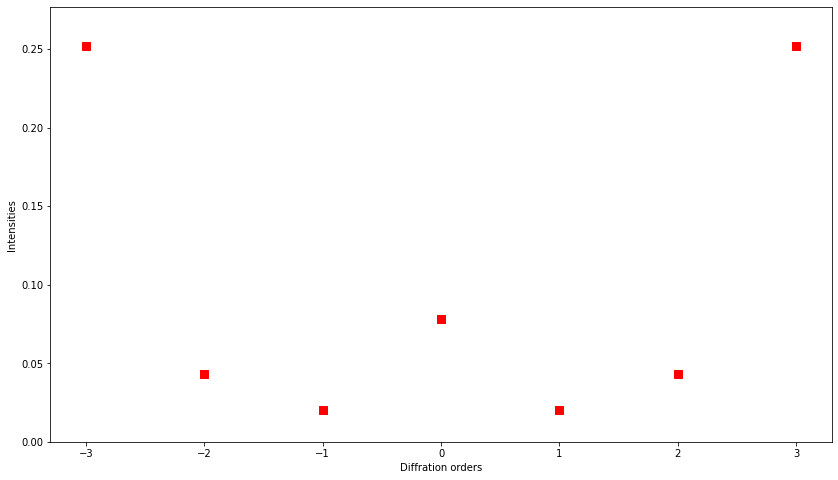

In [6]:
eff1 = Dammann_efficiencies(orders, transitions, phase_shift=np.pi, has_draw=True)
cost1=cost_Dammann1(eff1, effs_desired, normalize=False)
print(cost1)

## Ejemplo Óptimo

In [7]:
transitions_optimal=np.array([0, 0.201181, 0.250978, 0.326167,  0.370555,  0.372996,  0.396478,  0.453128,  0.594731, 0.670591, 0.717718,  0.890632, 0.919921, 0.935546])
orders_optimal = np.arange(0,21)
effs_desired_optimal=1/19*np.ones_like(orders_optimal)

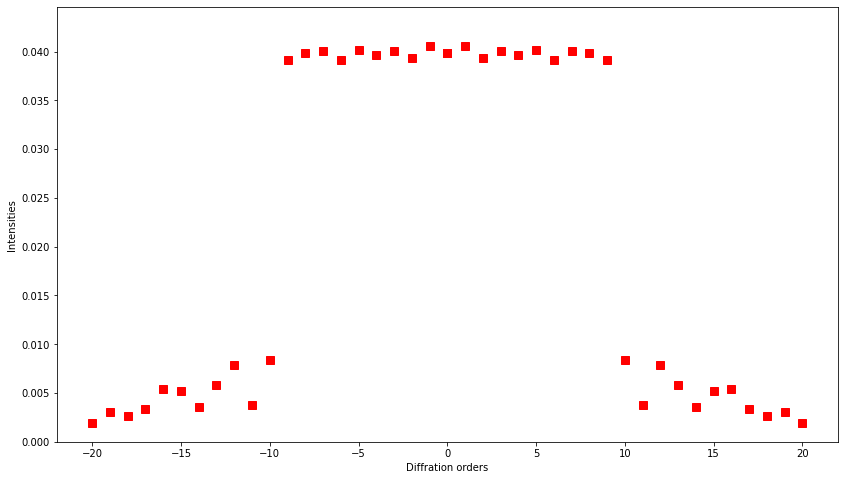

In [8]:
eff_optimal = Dammann_efficiencies(orders_optimal, transitions_optimal, phase_shift=np.pi, has_draw=True)

In [9]:
eff_optimal
effs_desired_optimal

array([0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158,
       0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158,
       0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158,
       0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158,
       0.05263158])

In [10]:
eff_total=eff_optimal.sum()
print("efficiencia total = {:2.2f} %".format(eff_total*100))

efficiencia total = 44.88 %


In [11]:
cost1=cost_Dammann1(eff1, effs_desired, normalize=False)
print(cost1)

0.2025464387192486


### Ejemplo N-D

In [12]:
def cost_Dammann(efficiencies_real, efficiencies_objective, normalize=True):
    """Evaluates the distance between the efficiencies given by transitions and desired efficiencies
    
    Arguments:
        efficiencies (np.array): efficiencies given by Dammann algorithm
        efficiencies_objective (np.array): desired efficiencies
        normalize (bool): If True, a normalization in the effficiencies is provided
        
    Returns:
        cost (float): cost function
    
    """
    
    if normalize is False:
        mnse = np.sqrt(((efficiencies_real-efficiencies_objective)**2).sum(axis=1))
    else:
        eff_real = efficiencies_real/efficiencies_real.sum(axis=0)
        eff_obj  = efficiencies_objective/efficiencies_objective.sum()
        mnse = np.sqrt(((eff_real-eff_obj)**2).sum(axis=1))

    return mnse

In [13]:
def Dammann_efficiencies_N(orders, transitions, phase_shift=np.pi):
    """ Compute de efficiency of a Dammann Grating

    Arguments:
        orders (np.array): diffraction orders to evaluation
        transitions (np.array): position of the transitions. Transitions are in the (0,1) range (period is normalized to 1)

    Returns:
        efficiencies (np.array): efficiencies of the Dammann grating for the orders and transitions

    Reference: 
        Optixplorer_Manual_v2.8d (pág 29)

    TODO:
        Remove for loops

    """
    # def Dammann_efficiencies_N(x,number_transitions,num_orders,n_particles):
    """""
    x: np.array a
    number_transitons: int
    num_orders: int

    """""

    num_particles, num_transitions = transitions.shape
    num_orders = orders.shape[0]
    efficiencies = np.zeros((num_particles,num_orders))


    #ef_max = np.zeros(n_particles)
    #ef_min = np.ones(n_particles)*(1/len(orders))

    sumatorio = 0

    for i, l in enumerate(orders):

        S, C, Q = 0, 0, 0

        for k in range(num_transitions):

            S = S + (-1)**(k+1) * np.sin(2*np.pi*l * transitions[:,k])
            C = C + (-1)**(k+1) * np.cos(2*np.pi*l * transitions[:,k])
            Q = Q + (-1)**(k+1) * (transitions[:,k])

        if l==0:
            ef = 1 - 4*Q*(1-Q)*np.sin(phase_shift/2)**2
            #print('EF_0',ef)

        else: 
            ef = np.sin(phase_shift/2)**2/(phase_shift*l)**2 * (C**2 + S**2)

        efficiencies[:,i] = ef
    
    return efficiencies

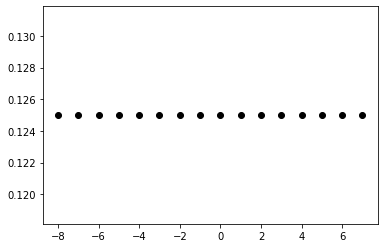

In [14]:
num_orders = 8
num_transitions = 10
num_particles = 75

orders = np.arange(-num_orders,num_orders)
effs_desired = 1/(2*num_orders+1)*np.ones_like(orders)
effs_desired = 1/num_orders*np.ones_like(orders)
plt.plot(orders, effs_desired,'ko')

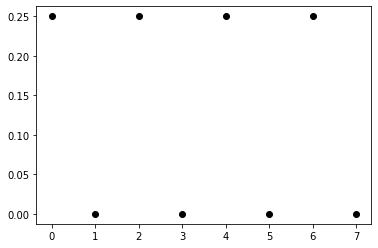

In [45]:
orders=np.arange(num_orders)
effs_desired=np.zeros_like(orders)
effs_desired[::2]=1
effs_desired=effs_desired/effs_desired.sum()

effs_desired, effs_desired.sum()

plt.plot(orders, effs_desired,'ko')

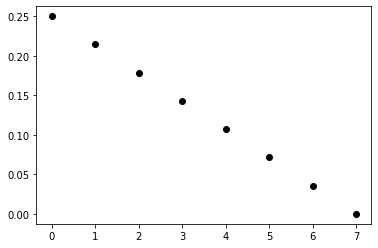

In [68]:
orders=np.arange(num_orders)
effs_desired=(num_orders-orders-1)
effs_desired=effs_desired/effs_desired.sum()

effs_desired, effs_desired.sum()

plt.plot(orders, effs_desired,'ko')

In [69]:
transitions=np.random.rand(num_particles,num_transitions)

phase_shift=np.pi

In [70]:
efficiencies = Dammann_efficiencies_N(orders, transitions, phase_shift=np.pi)

## Optimization

In [87]:
def optimize_Dammann(transitions, orders, effs_desired, phase_shift=np.pi/2):

    eff1 = Dammann_efficiencies_N(orders, transitions, phase_shift)
    cost1 = cost_Dammann(eff1, effs_desired, normalize=False)
    return cost1

## Algorithm

Es necesario incluir unos límites entre los que tienen que oscilar las transiciones de la red (Sería entre 0 y el periodo de la red). En este ejemplo varían entre 0 y 1:

In [88]:
min_bound = np.zeros(num_transitions)
max_bound = np.ones(num_transitions)
bounds = (min_bound, max_bound)

Utilizamos la función GlobalBestPSO de PySwarms para optimizar la función, cuyos argumentos son los siguientes:

- n_particles: # de partículas que el algoritmo utiliza para alcanzar el mínimo.
- dimensions: Las dimensiones corresponde con las trasiciones de nuestra red.
- options: 
   * c1 : float
      cognitive parameter
   * c2 : float
        social parameter
   * w : float
        inertia parameter 
- bounds: Restricciones mínima y máxima de las transiciones de la red



In [95]:
%%time


options = {'c1': 0.5, 'c2': 0.6, 'w': 0.9}
optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=num_transitions, options=options, bounds=bounds)

cost, pos_final = optimizer.optimize(optimize_Dammann, iters=1000, orders=orders, effs_desired=effs_desired, phase_shift= np.pi)

#pos_final.sort()
#print(pos_final)

2021-10-30 04:03:17,352 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.6, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.016
2021-10-30 04:03:23,883 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.016000589485453146, best pos: [0.52694565 0.65333845 0.71254522 0.66268624 0.63953736 0.83053928
 0.68147005 0.53313753 0.70748096 0.83569082]


CPU times: user 6.77 s, sys: 389 ms, total: 7.16 s
Wall time: 6.55 s


In [96]:
pos_final

array([0.52694565, 0.65333845, 0.71254522, 0.66268624, 0.63953736,
       0.83053928, 0.68147005, 0.53313753, 0.70748096, 0.83569082])

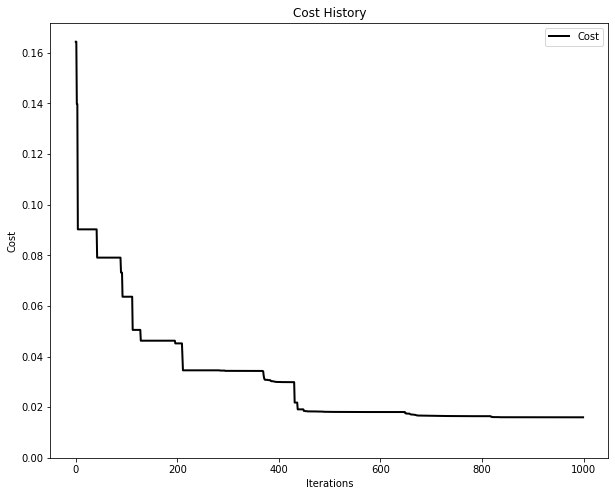

In [97]:
plot_cost_history(cost_history=optimizer.cost_history)
plt.ylim(ymin=0)
plt.show()

[2.55200637e-01 2.20878105e-01 1.76749374e-01 1.44006355e-01
 1.10859249e-01 6.67765749e-02 2.99967384e-02 1.06173947e-02
 2.14906154e-03 5.23971284e-03 1.79733363e-02 2.47583435e-02
 1.91058994e-02 1.03113655e-02 4.01013339e-03 8.07226139e-04
 2.89978867e-03 6.52732841e-03 4.93056709e-03 9.15118670e-04
 2.30550331e-04] 1.5601868010474207 1.974685080330135


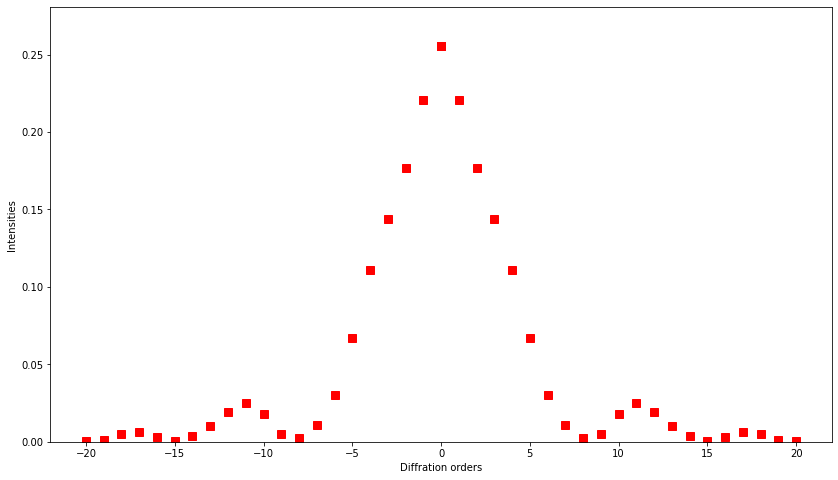

In [99]:
eff_final = Dammann_efficiencies(np.arange(0,21), pos_final, phase_shift=np.pi, has_draw=True)
print(eff_final, 2*eff_final[eff_final>0.1].sum()-eff_final[0], 2*eff_final.sum()-eff_final[0])
#plt.ylim(0,0.1)

In [100]:
mnse = np.sqrt(((eff1-effs_desired)**2).sum())
print(mnse)

0.01312040512456244


0.014739081217246342


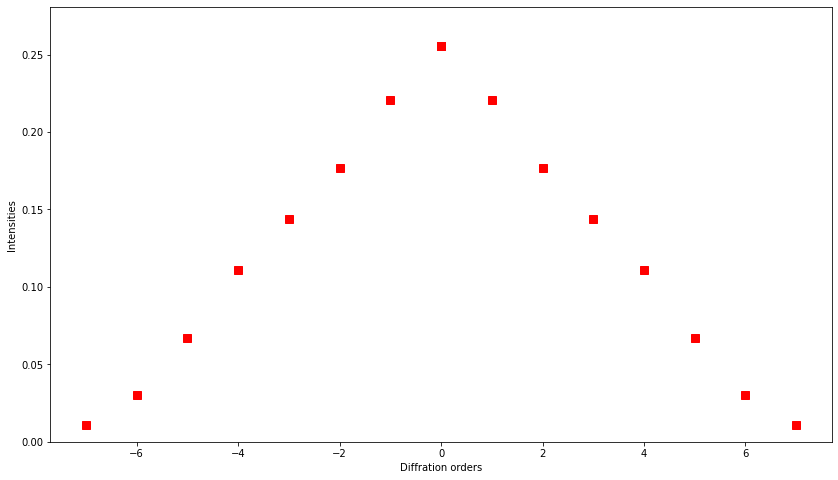

In [101]:
eff1 = Dammann_efficiencies(orders, pos_final, phase_shift=np.pi, has_draw=True)

cost1=cost_Dammann1(eff1, effs_desired, normalize=True)

print(cost1)

### Si ordenamos no funciona

In [79]:
pos_final_sorted=np.sort(pos_final)

0.7862169072412334


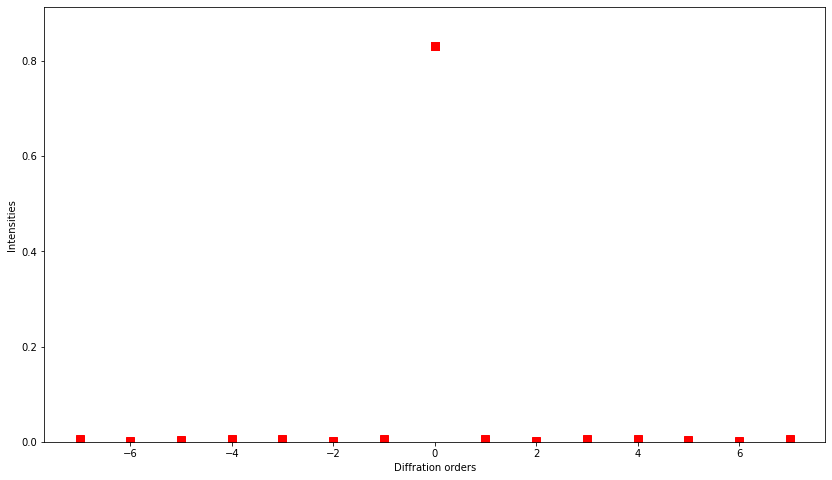

In [80]:
eff1 = Dammann_efficiencies(orders, pos_final_sorted, phase_shift=np.pi, has_draw=True)

cost1=cost_Dammann1(eff1, effs_desired, normalize=True)

print(cost1)

## Conclusiones
- el algortimo no es del todo bueno, porque no se pueden ordenar las transiciones y eso es incongruente
- el número de transiciones tiene que ser par